# Import Libaries

In [1]:
1+1

2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, precision_score, precision_recall_curve
from scipy.stats.mstats import winsorize

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers, optimizers
import keras_tuner as kt
from keras.metrics import AUC

2025-07-22 22:47:16.291630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 22:47:16.788083: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 22:47:17.293278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753199237.746258   49172 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753199237.885370   49172 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753199238.898175   49172 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Import data

In [2]:
bs_ratio = pd.read_csv("BS_ratio_df_cleaned.csv")
bs = pd.read_csv("BS_df_cleaned.csv")

pnl_ratio = pd.read_csv("PNL_ratio_df_cleaned.csv")
pnl = pd.read_csv("PNL_df_cleaned.csv")

cf = pd.read_csv("CF_df_cleaned.csv")

cross = pd.read_csv("crossstatement_ratio_df_cleaned.csv")


# Selected features from extant literature

In [3]:
features_in_bs_ratio = ["Cash & Cash Equivalents to Total Assets",
                 "Total Liabilities Percentage of Total Assets", #Note
                 "Current Ratio",
                 "Quick Ratio",
                 "Inventories Percentage of Total Assets", #Note
                 "Inventories Percentage of Total Current Assets", #Note
                 "Date", "Instrument",]

features_in_bs = ["Total Assets", "Total Liabilities",
                    "Total Current Assets", "Total Current Liabilities",
                    "Cash & Cash Equivalents", "Inventories - Total",
                    "Shareholders' Equity - Attributable to Parent ShHold - Total",
                    "Debt - Total", "Total Fixed Assets - Net",
                    "Working Capital - Non-Cash", "Short-Term Debt & Current Portion of Long-Term Debt",
                    "Debt - Long-Term - Total", "Accounts Payable",
                    "Intangible Assets - excluding Goodwill - Net - Total",
                    "Date", "Instrument", "Target"]

features_in_pnl_ratio = ["Operating Margin - %", "Net Margin - %", 
                         "Date", "Instrument"]

features_in_pnl = ["Net Income after Tax","Operating Expenses",
                   "Revenue from Business Activities - Total",
                   "Cost of Operating Revenue", "Sales of Goods & Services - Net",
                   "Normalized Pre-tax Profit",
                   "Selling General & Administrative Expenses - Total",
                   "Date", "Instrument"]

features_in_cf = ["Net Cash Flow from Operating Activities",
                  "Date", "Instrument"]

features_in_cross = ["Inventory Turnover", "Operating Cycle Days", # วันไม่ตรงไม่ใช้ เดี๋ยวสร้างเอง
                     "Reinvestment Rate - %, TTM", # วันไม่ตรงข้อมูลไม่พอ ลบออก
                     "Date", "Instrument"]

In [4]:
bs_ratio = bs_ratio[features_in_bs_ratio]
bs = bs[features_in_bs]
pnl_ratio = pnl_ratio[features_in_pnl_ratio]
pnl = pnl[features_in_pnl]
cf = cf[features_in_cf]
cross = cross[features_in_cross]

In [5]:
print(bs_ratio.shape)
print(bs.shape)
print(pnl_ratio.shape)
print(pnl.shape)
print(cf.shape)
print(cross.shape)

(937, 8)
(937, 17)
(937, 4)
(937, 9)
(937, 3)
(920, 5)


In [6]:
df =  bs_ratio.merge(bs, on=["Date", "Instrument"], how="left") \
        .merge(pnl_ratio, on=["Date", "Instrument"], how="left") \
        .merge(pnl, on=["Date", "Instrument"], how="left") \
        .merge(cf, on=["Date", "Instrument"], how="left") \
        .merge(cross, on=["Date", "Instrument"], how="left")

In [7]:
df.insert(0, "Instrument", df.pop("Instrument"))
df.insert(0, "Date", df.pop("Date"))
df["Target"] = df.pop("Target")

print(df.columns.tolist())

['Date', 'Instrument', 'Cash & Cash Equivalents to Total Assets', 'Total Liabilities Percentage of Total Assets', 'Current Ratio', 'Quick Ratio', 'Inventories Percentage of Total Assets', 'Inventories Percentage of Total Current Assets', 'Total Assets', 'Total Liabilities', 'Total Current Assets', 'Total Current Liabilities', 'Cash & Cash Equivalents', 'Inventories - Total', "Shareholders' Equity - Attributable to Parent ShHold - Total", 'Debt - Total', 'Total Fixed Assets - Net', 'Working Capital - Non-Cash', 'Short-Term Debt & Current Portion of Long-Term Debt', 'Debt - Long-Term - Total', 'Accounts Payable', 'Intangible Assets - excluding Goodwill - Net - Total', 'Operating Margin - %', 'Net Margin - %', 'Net Income after Tax', 'Operating Expenses', 'Revenue from Business Activities - Total', 'Cost of Operating Revenue', 'Sales of Goods & Services - Net', 'Normalized Pre-tax Profit', 'Selling General & Administrative Expenses - Total', 'Net Cash Flow from Operating Activities', 'Inv

In [8]:
df["ln_total_assets"] = np.log(df["Total Assets"])
df["ROA"] = df["Net Income after Tax"] / df["Total Assets"]
df["net_income_to_current_assets"] = df["Net Income after Tax"] / df["Total Current Assets"]
df["operating_expense_to_sales"] = df["Operating Expenses"] / df["Revenue from Business Activities - Total"]
df["gross_profit_margin"] = (df["Revenue from Business Activities - Total"] - df["Cost of Operating Revenue"]) / df["Sales of Goods & Services - Net"]
df["operating_income_margin"] = (df["Revenue from Business Activities - Total"] - df["Cost of Operating Revenue"] - df["Operating Expenses"]) / df["Revenue from Business Activities - Total"]
df["inventory_turnover"] = df["Cost of Operating Revenue"] / df["Inventories - Total"]
df["operating_cashflow_ratio"] = df["Net Cash Flow from Operating Activities"] / df["Total Current Liabilities"]
df["pretax_profit_margin"] = df["Normalized Pre-tax Profit"] / df["Sales of Goods & Services - Net"]
df["ROE"] = df["Net Income after Tax"] / df["Shareholders' Equity - Attributable to Parent ShHold - Total"]
df["fixed_assests_to_total_assets"] = df["Total Fixed Assets - Net"] / df["Total Assets"]
df["working_capital_noncash_to_total_assets"] = df["Working Capital - Non-Cash"] / df["Total Assets"]
df["growth_revenue"] = df["Revenue from Business Activities - Total"].pct_change()
df["growth_ncwc"] = df["Working Capital - Non-Cash"].pct_change()
df["sg&a_to_revenue"] = df["Selling General & Administrative Expenses - Total"] / df["Revenue from Business Activities - Total"]
df["invest_bear_lia_to_equity"] = (df["Short-Term Debt & Current Portion of Long-Term Debt"] + df["Debt - Long-Term - Total"]) / df["Shareholders' Equity - Attributable to Parent ShHold - Total"]
df["APTR"] = df["Accounts Payable"] / df["Cost of Operating Revenue"]
df["GP"] = df["Intangible Assets - excluding Goodwill - Net - Total"] / df["Total Assets"]
df["accural"] = df["Net Income after Tax"] - df["Net Cash Flow from Operating Activities"]

In [9]:
df.shape

(937, 55)

In [10]:
df1 = df.copy()
df1 = df1[["Instrument", "Date", "ln_total_assets", "ROA", 
          "net_income_to_current_assets", "Inventories Percentage of Total Assets",
          "Inventories Percentage of Total Current Assets",
          "Cash & Cash Equivalents to Total Assets",
          "operating_expense_to_sales",
          "gross_profit_margin", "operating_income_margin",
          "Total Liabilities Percentage of Total Assets",
          "Current Ratio", "Quick Ratio",
          "inventory_turnover", "operating_cashflow_ratio",
          "pretax_profit_margin",
          "Net Margin - %",
          "ROE", "fixed_assests_to_total_assets",
          "working_capital_noncash_to_total_assets",
          "growth_revenue", "growth_ncwc", "sg&a_to_revenue",
          "invest_bear_lia_to_equity", "APTR", "GP", "accural",
          "Target"]]

In [11]:
df1

Instrument        Date  ln_total_assets       ROA  \
0        KC.BK  2024-12-31        20.688713 -0.140323   
1        KC.BK  2023-12-31        20.771775 -0.062691   
2        KC.BK  2022-12-31        20.692272 -0.091602   
3        KC.BK  2021-12-31        20.732728 -0.074965   
4        KC.BK  2020-12-31        20.546625 -0.123026   
..         ...         ...              ...       ...   
932   TPCHm.BK  2009-12-31        22.540462  0.049401   
933   TPCHm.BK  2008-12-31        22.540462  0.049401   
934   TPCHm.BK  2007-12-31        22.540462  0.049401   
935   TPCHm.BK  2006-12-31        22.540462  0.049401   
936   TPCHm.BK  2005-12-31        22.540462  0.049401   

     net_income_to_current_assets  Inventories Percentage of Total Assets  \
0                       -0.322647                               12.207070   
1                       -0.117267                               12.999080   
2                       -0.139587                               22.042970   
3                       -0.100216                               27.616430   
4                       -0.182602                               31.498170   
..                            ...                                     ...   
932                      0.237580                                0.415156   
933                      0.237580                                0.415156   
934                      0.237580                                0.415156   
935                      0.237580                                0.415156   
936                      0.237580                                0.415156   

     Inventories Percentage of Total Current Assets  \
0                                         28.067940   
1                                         24.315370   
2                                         33.590290   
3                                         36.918660   
4                                         46.751590   
..                                              ...   
932                                        2.436355   
933                                        2.436355   
934                                        2.436355   
935                                        2.436355   
936                                        2.436355   

     Cash & Cash Equivalents to Total Assets  operating_expense_to_sales  \
0                                   0.034570                    2.196268   
1                                   0.141950                    1.201147   
2                                   0.150890                    1.267552   
3                                   0.194820                    1.573818   
4                                   0.023080                    1.506129   
..                                       ...                         ...   
932                                 0.069801                    0.741328   
933                                 0.069801                    0.741328   
934                                 0.069801                    0.741328   
935                                 0.069801                    0.741328   
936                                 0.069801                    0.741328   

     gross_profit_margin  ...  fixed_assests_to_total_assets  \
0               0.181340  ...                       0.545830   
1               0.225256  ...                       0.465397   
2               0.255361  ...                       0.343770   
3               0.259974  ...                       0.251966   
4               0.257600  ...                       0.326265   
..                   ...  ...                            ...   
932             0.335385  ...                       0.790566   
933             0.335385  ...                       0.790566   
934             0.335385  ...                       0.790566   
935             0.335385  ...                       0.790566   
936             0.335385  ...                       0.790566   

     working_capital_noncash_to_total_assets  growt

In [12]:
df1.isna().sum()

Instrument                                        0
Date                                              0
ln_total_assets                                   0
ROA                                               0
net_income_to_current_assets                      0
Inventories Percentage of Total Assets            0
Inventories Percentage of Total Current Assets    0
Cash & Cash Equivalents to Total Assets           0
operating_expense_to_sales                        0
gross_profit_margin                               3
operating_income_margin                           0
Total Liabilities Percentage of Total Assets      0
Current Ratio                                     0
Quick Ratio                                       0
inventory_turnover                                3
operating_cashflow_ratio                          0
pretax_profit_margin                              0
Net Margin - %                                    3
ROE                                               0
fixed_assest

In [13]:
df2 = df1.copy()

## Clean NaN and inf

In [14]:
num_cols = df2.select_dtypes(include=[np.number]).columns
cols = num_cols.drop("Target")
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

df2[num_cols] = (df2.groupby('Instrument')[num_cols].transform(lambda grp: grp.fillna(grp.mean())))
df2[num_cols] = df2[num_cols].fillna(0)

df2[num_cols].isna().sum()

ln_total_assets                                   0
ROA                                               0
net_income_to_current_assets                      0
Inventories Percentage of Total Assets            0
Inventories Percentage of Total Current Assets    0
Cash & Cash Equivalents to Total Assets           0
operating_expense_to_sales                        0
gross_profit_margin                               0
operating_income_margin                           0
Total Liabilities Percentage of Total Assets      0
Current Ratio                                     0
Quick Ratio                                       0
inventory_turnover                                0
operating_cashflow_ratio                          0
pretax_profit_margin                              0
Net Margin - %                                    0
ROE                                               0
fixed_assests_to_total_assets                     0
working_capital_noncash_to_total_assets           0
growth_reven

## Save to csv

In [15]:
df2.to_csv("SelectedFeatures_cleaned.csv", index=False)

## Visualization

In [16]:
df2[num_cols].describe().T

count          mean  \
ln_total_assets                                 937.0  2.197982e+01   
ROA                                             937.0 -1.332406e-02   
net_income_to_current_assets                    937.0 -2.238014e-01   
Inventories Percentage of Total Assets          937.0  1.764171e+01   
Inventories Percentage of Total Current Assets  937.0  3.678950e+01   
Cash & Cash Equivalents to Total Assets         937.0  6.956806e-02   
operating_expense_to_sales                      937.0  1.073401e+00   
gross_profit_margin                             937.0  2.218346e-01   
operating_income_margin                         937.0 -8.948221e-01   
Total Liabilities Percentage of Total Assets    937.0  5.385474e+01   
Current Ratio                                   937.0  2.386921e+00   
Quick Ratio                                     937.0  1.955423e+00   
inventory_turnover                              937.0  6.644669e+01   
operating_cashflow_ratio                        937.0  1.545421e-01   
pretax_profit_margin                            937.0 -1.836351e-01   
Net Margin - %                                  937.0 -2.332130e+01   
ROE                                             937.0 -3.512307e-01   
fixed_assests_to_total_assets                   937.0  5.136567e-01   
working_capital_noncash_to_total_assets         937.0 -2.806180e-02   
growth_revenue                                  937.0  5.019004e-01   
growth_ncwc                                     937.0 -1.884681e+00   
sg&a_to_revenue                                 937.0  3.253098e-01   
invest_bear_lia_to_equity                       937.0  2.634430e+00   
APTR                                            937.0  3.252958e-01   
GP                                              937.0  5.938110e-01   
accural                                         937.0 -2.308329e+08   
Target                                          937.0  5.101387e-01   

                                                         std           min  \
ln_total_assets                                 1.333060e+00  1.787045e+01   
ROA                                             2.135590e-01 -2.366689e+00   
net_income_to_current_assets                    4.306841e+00 -7.496324e+01   
Inventories Percentage of Total Assets          2.023275e+01 -1.775100e-01   
Inventories Percentage of Total Current Assets  3.000138e+01 -7.396963e+01   
Cash & Cash Equivalents to Total Assets         8.780779e-02  2.000000e-05   
operating_expense_to_sales                      7.774534e-01 -1.359999e+00   
gross_profit_margin                             6.500028e-01 -1.574535e+00   
operating_income_margin                         2.190130e+00 -5.638418e+01   
Total Liabilities Percentage of Total Assets    5.368373e+01  1.115780e+00   
Current Ratio                                   3.536216e+00  1.850000e-03   
Quick Ratio                                     4.344688e+00 -1.733000e-02   
inventory_turnover                              4.104782e+02  0.000000e+00   
operating_cashflow_ratio                        2.511272e+00 -5.341449e+01   
pretax_profit_margin                            1.294351e+00 -1.889483e+01   
Net Margin - %                                  1.257010e+02 -1.993689e+03   
ROE                                             8.120023e+00 -2.131988e+02   
fixed_assests_to_total_assets                   2.811306e-01 -4.117454e-01   
working_capital_noncash_to_total_assets         5.657198e-01 -1.046021e+01   
growth_revenue                                  3.525447e+00 -1.000000e+00   
growth_ncwc                                     4.019560e+01 -1.199412e+03   
sg&a_to_revenue                                 7.409126e-01 -2.405091e-01   
invest_bear_lia_to_equity                       2.612793e+01 -2.102972e+02   
APTR                                            1.598602e+00  0.000000e+00   
GP                                              5.186069e+00 -4.969213e+00   
accural                        

In [17]:
cols_frez = ["Inventories Percentage of Total Assets",
             "Inventories Percentage of Total Current Assets",
             "inventory_turnover", 
             "fixed_assests_to_total_assets",
             "APTR"]

mask = (df2[cols_frez] < 0).any(axis=1)

df2.loc[mask,["Instrument", "Date"] + cols_frez + ["Target"]]

Instrument        Date  Inventories Percentage of Total Assets  \
77   POLAR.BK^A25  2006-12-31                                -0.17751   
351    STOWERm.BK  2012-12-31                                36.80899   
352    STOWERm.BK  2011-12-31                                35.35529   
354    STOWERm.BK  2009-12-31                                37.93910   
355    STOWERm.BK  2008-12-31                                56.76726   
356    STOWERm.BK  2007-12-31                                57.86203   
357    STOWERm.BK  2006-12-31                                50.89710   
358    STOWERm.BK  2005-12-31                                42.23713   

     Inventories Percentage of Total Current Assets  inventory_turnover  \
77                                        -73.96963           -0.000000   
351                                        49.27884            1.284800   
352                                        50.68807            2.072070   
354                                        61.00148            3.065194   
355                                        72.36916            1.349983   
356                                        78.86019            1.871910   
357                                        67.57945            1.527228   
358                                        61.29838            2.123046   

     fixed_assests_to_total_assets      APTR  Target  
77                        0.997600  2.433848       1  
351                      -0.212764  0.001332       1  
352                      -0.287369  0.000846       1  
354                      -0.374511  0.135537       1  
355                      -0.294583  0.164579       1  
356                      -0.310734  0.125619       1  
357                      -0.343521  0.171187       1  
358                      -0.411745  0.156202       1

In [18]:
df2 = df2[~mask]

array([[<Axes: title={'center': 'ln_total_assets'}>,
        <Axes: title={'center': 'ROA'}>,
        <Axes: title={'center': 'net_income_to_current_assets'}>,
        <Axes: title={'center': 'Inventories Percentage of Total Assets'}>,
        <Axes: title={'center': 'Inventories Percentage of Total Current Assets'}>,
        <Axes: title={'center': 'Cash & Cash Equivalents to Total Assets'}>],
       [<Axes: title={'center': 'operating_expense_to_sales'}>,
        <Axes: title={'center': 'gross_profit_margin'}>,
        <Axes: title={'center': 'operating_income_margin'}>,
        <Axes: title={'center': 'Total Liabilities Percentage of Total Assets'}>,
        <Axes: title={'center': 'Current Ratio'}>,
        <Axes: title={'center': 'Quick Ratio'}>],
       [<Axes: title={'center': 'inventory_turnover'}>,
        <Axes: title={'center': 'operating_cashflow_ratio'}>,
        <Axes: title={'center': 'pretax_profit_margin'}>,
        <Axes: title={'center': 'Net Margin - %'}>,
        <

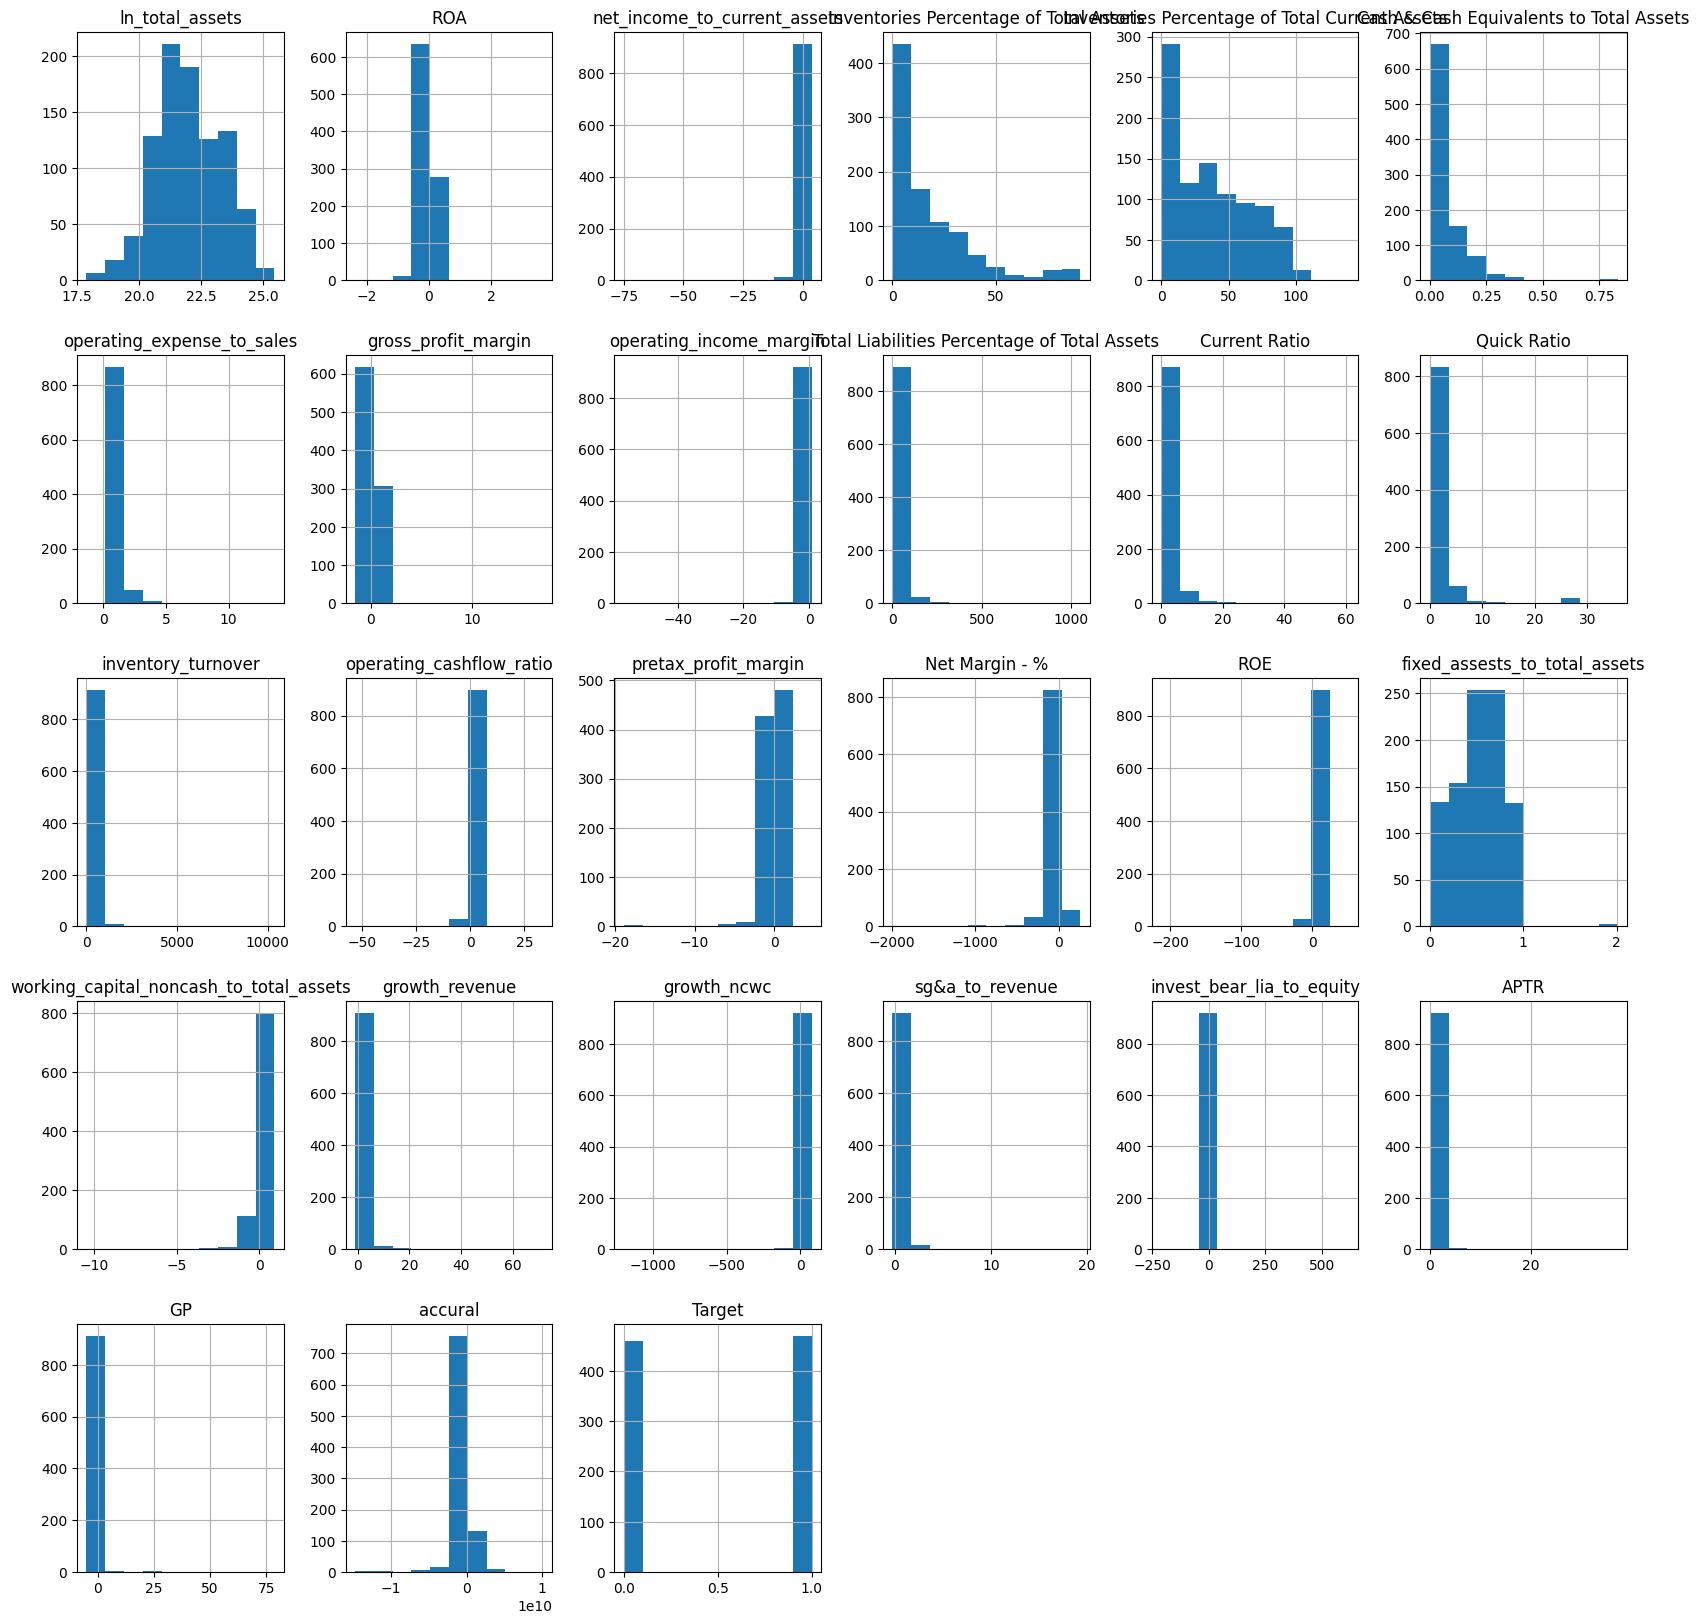

In [19]:
df2[num_cols].hist(layout=(5, 6), figsize=(20, 20))

/tmp/ipykernel_49172/1225860667.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=df_long, x = 'Target', y='Value',


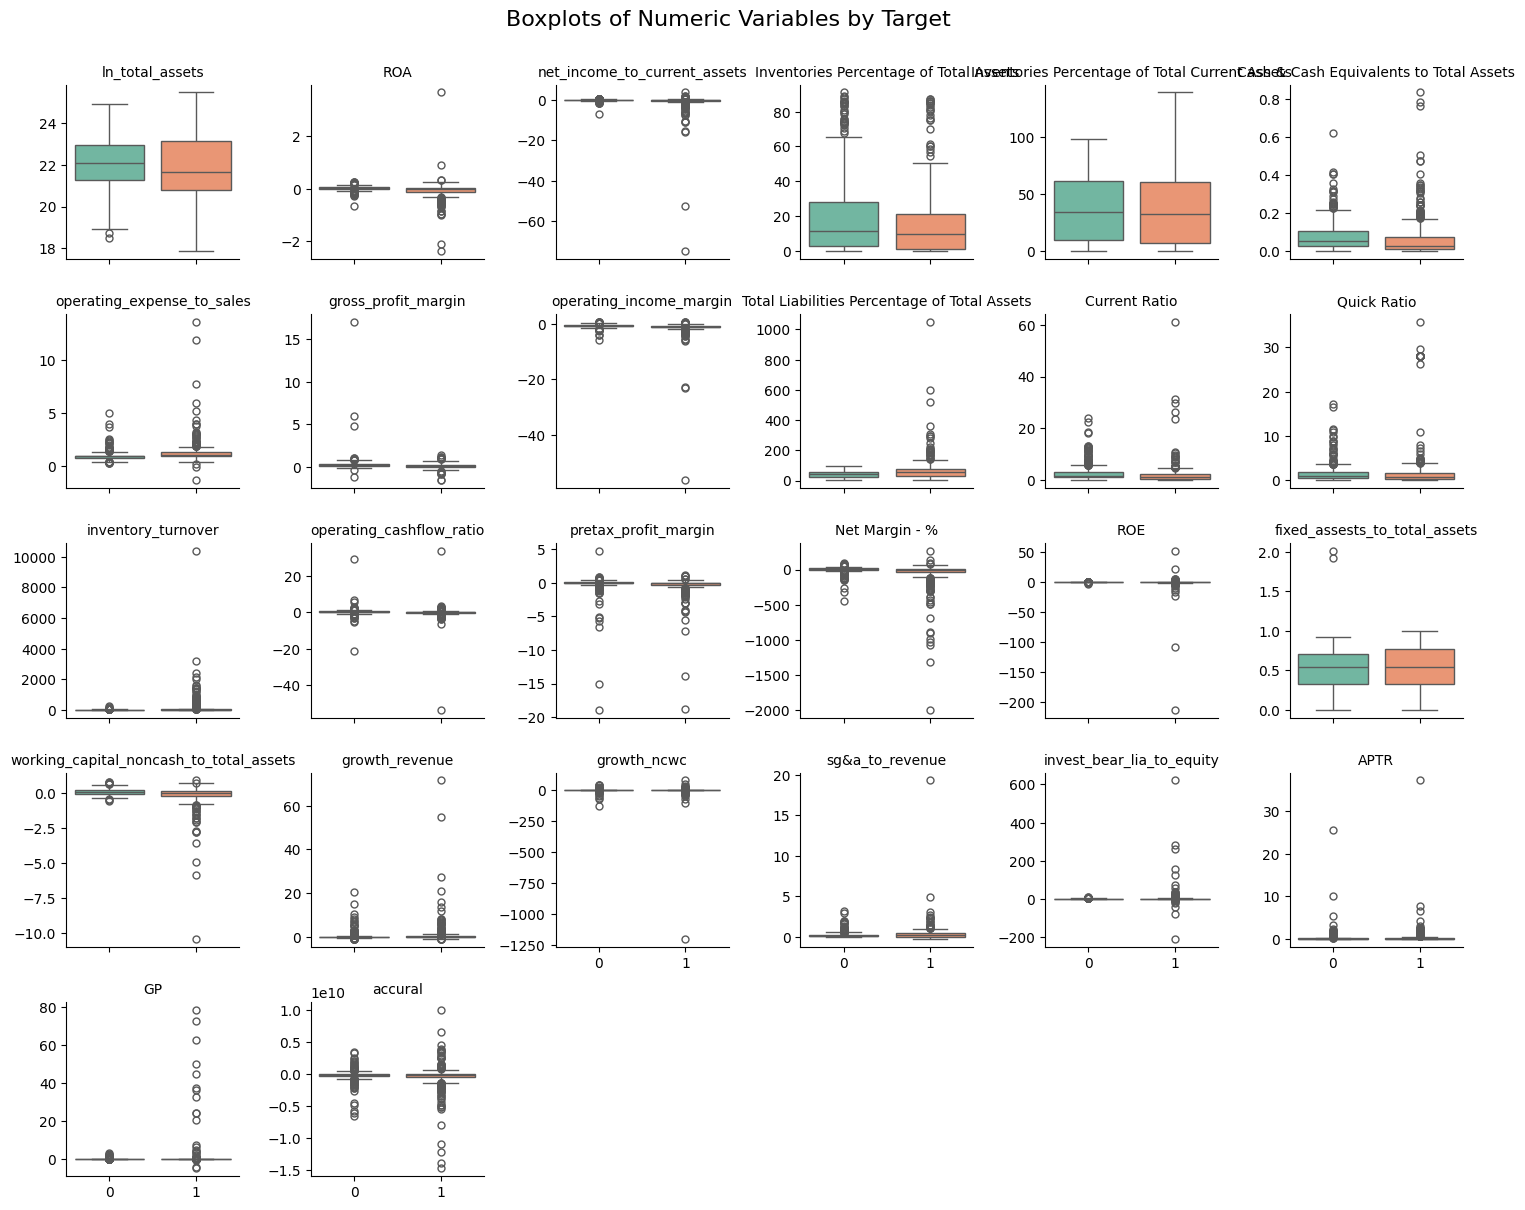

In [20]:
df_long = df2.melt(id_vars='Target',value_vars=num_cols,var_name='Variable',value_name='Value')

g = sns.catplot(data=df_long, x = 'Target', y='Value',
                col='Variable', kind='box', col_wrap=6,
                sharey=False, height=2.5, aspect=1, palette='Set2')

g.set_titles('{col_name}')
g.figure.subplots_adjust(top=0.92)
g.figure.suptitle('Boxplots of Numeric Variables by Target', fontsize=16)
for ax in g.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

<Axes: >

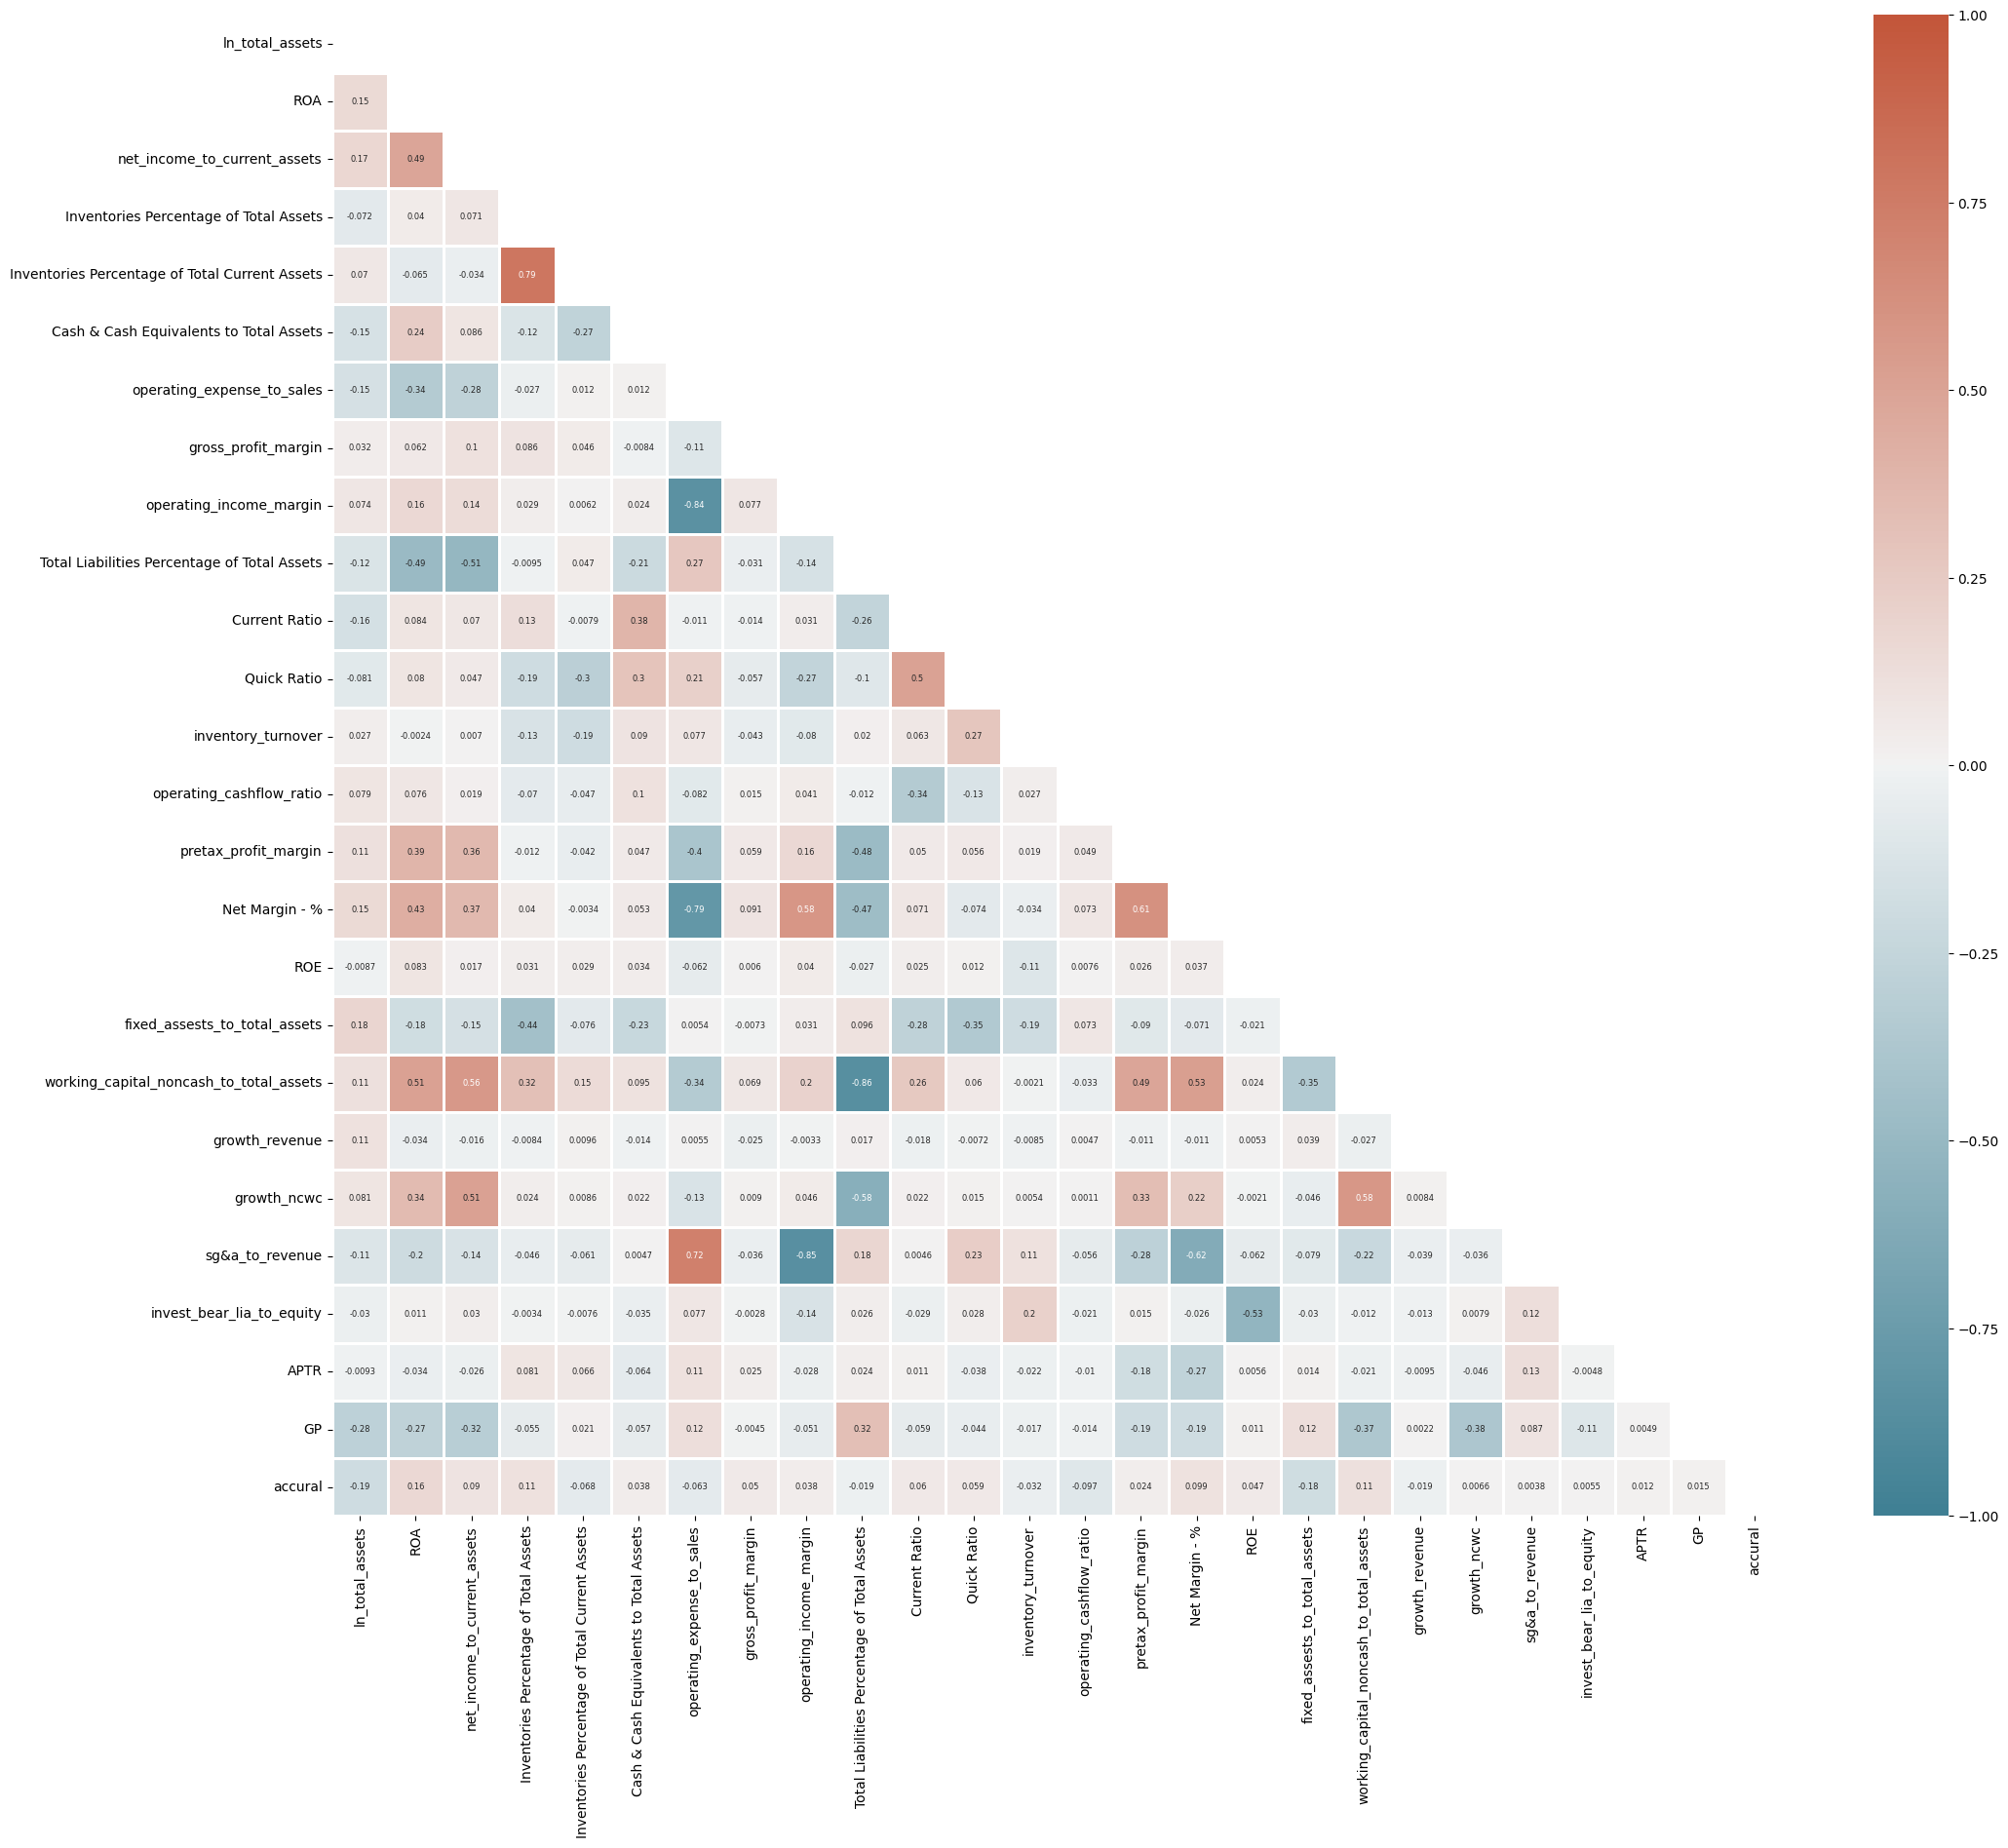

In [21]:
dcorr = df2[cols].corr()
mask = np.zeros_like(dcorr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(24,20))
sns.heatmap(dcorr, cmap=sns.diverging_palette(220, 20, as_cmap=True),
            vmin=-1, vmax=1, center=0, linewidths=1, annot=True, 
            mask=mask, ax=ax, annot_kws={"fontsize":6})

/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/seaborn/axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed

<Figure size 3000x3000 with 0 Axes>

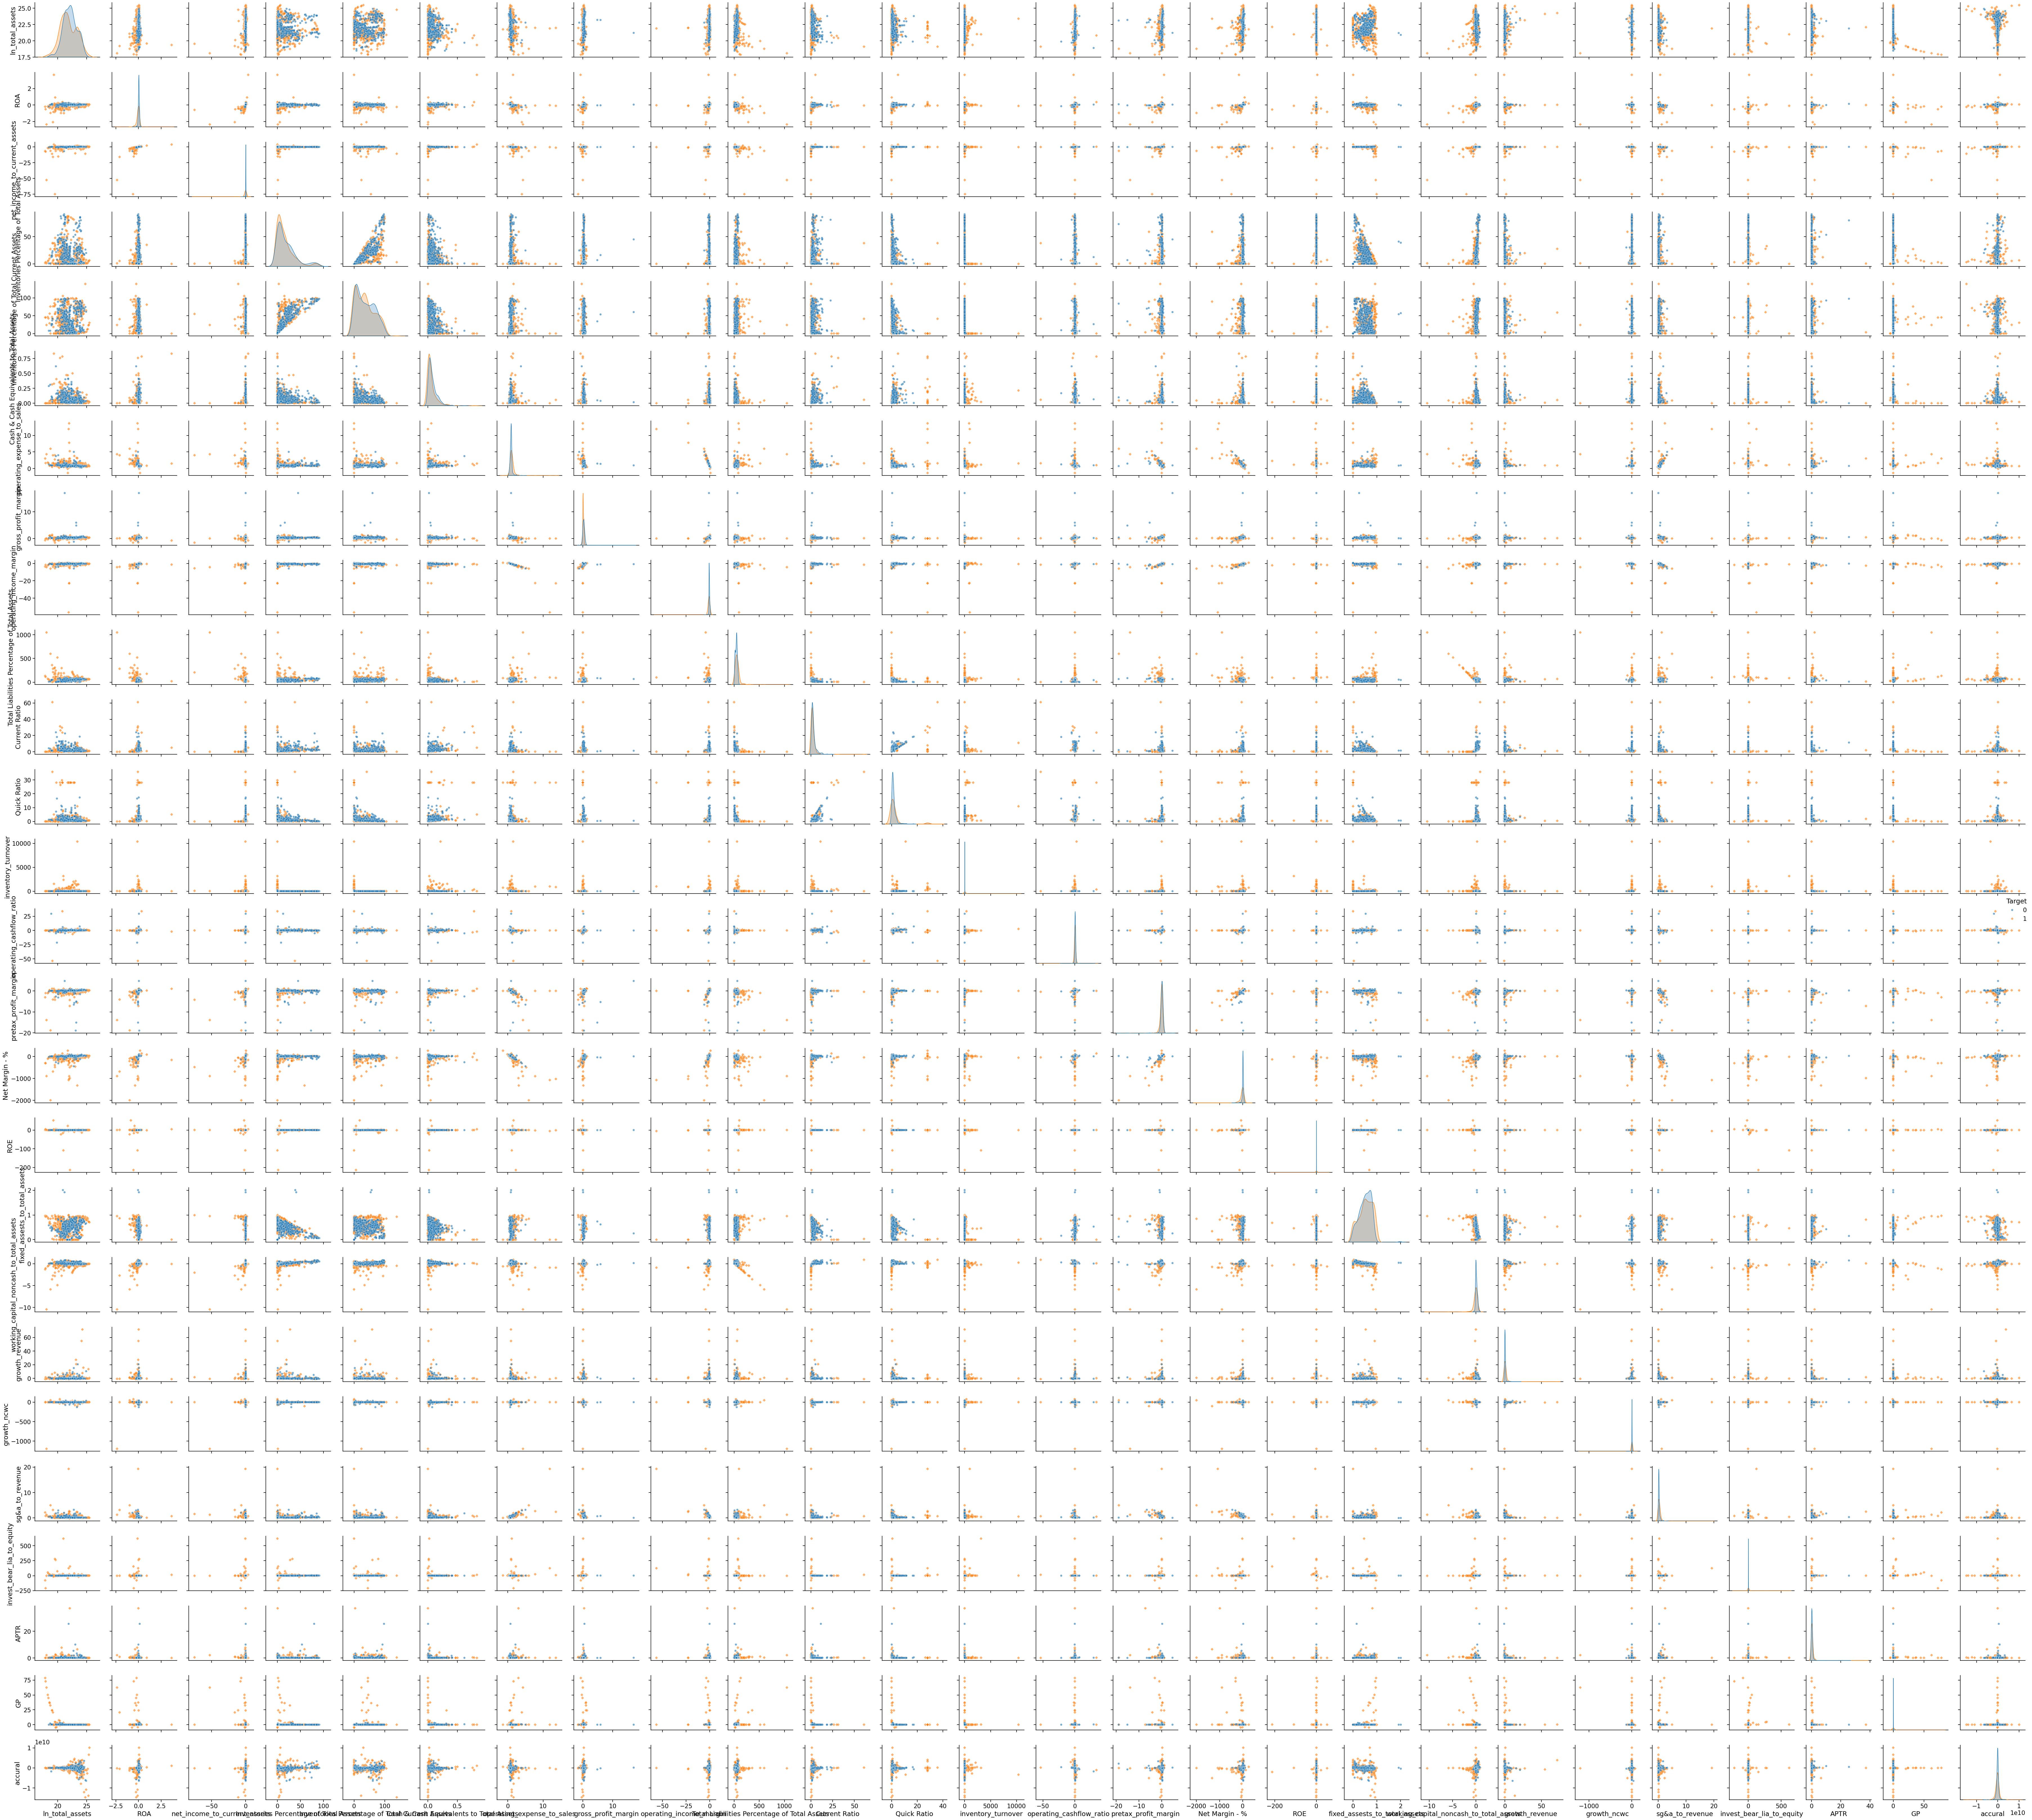

In [22]:
sns.set_context("notebook", font_scale=1.4)
plt.figure(figsize=(20, 20), dpi=150)
g = sns.pairplot(df2, vars=cols,
                 hue="Target", markers=['o','D','+'],
                 plot_kws={'alpha': .6, 's': 30}, height=2.5, aspect=1.1)
plt.tight_layout()
plt.show()

# T-distrubution

In [23]:
df2[num_cols].groupby("Target").agg(["mean", "std"])

ln_total_assets                 ROA            \
                  mean       std      mean       std   
Target                                                 
0            22.131152  1.179416  0.030355  0.075863   
1            21.860366  1.450143 -0.056258  0.285549   

       net_income_to_current_assets            \
                               mean       std   
Target                                          
0                          0.070069  0.392385   
1                         -0.698694  4.519477   

       Inventories Percentage of Total Assets             \
                                         mean        std   
Target                                                     
0                                   19.120277  21.108784   
1                                   15.822089  19.053243   

       Inventories Percentage of Total Current Assets             ...  \
                                                 mean        std  ...   
Target                                                            ...   
0                                           37.122456  29.100033  ...   
1                                           36.309458  30.514103  ...   

       sg&a_to_revenue           invest_bear_lia_to_equity             \
                  mean       std                      mean        std   
Target                                                                  
0             0.261195  0.333516                  0.832756   1.085366   
1             0.391064  0.988591                  4.435789  36.806793   

            APTR                  GP                 accural                
            mean       std      mean       std          mean           std  
Target                                                                      
0       0.264563  1.333490  0.070372  0.270939 -1.526274e+08  8.008213e+08  
1       0.383359  1.829324  1.119923  7.283224 -3.111586e+08  1.715894e+09  

[2 rows x 52 columns]

In [24]:
results = []

for feat in df2[num_cols].columns:
    if feat == 'Target':
        continue
    # แยกกลุ่มตาม Target
    tmp = df2[num_cols][[feat, "Target"]].dropna()
    g0 = df2[num_cols].loc[df2[num_cols]['Target'] == 0, feat]
    g1 = df2[num_cols].loc[df2[num_cols]['Target'] == 1, feat]

    # คำนวณ mean และ std
    m0, s0 = g0.mean(), g0.std()
    m1, s1 = g1.mean(), g1.std()

    # t-test แบบ Welch
    t_stat, p_t = ttest_ind(g0, g1, equal_var=False)
    
    # t-stat test
    sig_t = p_t < 0.05

    results.append({'feature'         : feat,
                    'mean_0'          : m0,
                    'mean_1'          : m1,
                    'std_0'           : s0,
                    'std_1'           : s1,
                    't-statistic'     : t_stat,
                    't_pvalue'        : p_t,
                    'sig_t_0.05'      : sig_t,})

# สร้าง DataFrame สรุป
stats_df = pd.DataFrame(results).set_index('feature')

# แสดงผล
stats_df


mean_0        mean_1  \
feature                                                                      
ln_total_assets                                 2.213115e+01  2.186037e+01   
ROA                                             3.035467e-02 -5.625845e-02   
net_income_to_current_assets                    7.006914e-02 -6.986941e-01   
Inventories Percentage of Total Assets          1.912028e+01  1.582209e+01   
Inventories Percentage of Total Current Assets  3.712246e+01  3.630946e+01   
Cash & Cash Equivalents to Total Assets         7.708416e-02  6.233544e-02   
operating_expense_to_sales                      9.280542e-01  1.214661e+00   
gross_profit_margin                             3.163421e-01  1.323833e-01   
operating_income_margin                        -6.130092e-01 -1.167245e+00   
Total Liabilities Percentage of Total Assets    4.303889e+01  6.465036e+01   
Current Ratio                                   2.738904e+00  2.039831e+00   
Quick Ratio                                     1.576328e+00  2.343395e+00   
inventory_turnover                              8.877449e+00  1.237713e+02   
operating_cashflow_ratio                        3.064406e-01  8.661626e-03   
pretax_profit_margin                           -6.924779e-02 -2.952167e-01   
Net Margin - %                                  3.178013e+00 -4.910453e+01   
ROE                                             5.381833e-02 -7.507896e-01   
fixed_assests_to_total_assets                   5.093398e-01  5.292488e-01   
working_capital_noncash_to_total_assets         8.904962e-02 -1.456140e-01   
growth_revenue                                  2.525622e-01  7.546678e-01   
growth_ncwc                                    -7.693553e-01 -3.003769e+00   
sg&a_to_revenue                                 2.611953e-01  3.910642e-01   
invest_bear_lia_to_equity                       8.327565e-01  4.435789e+00   
APTR                                            2.645628e-01  3.833588e-01   
GP                                              7.037185e-02  1.119923e+00   
accural                                        -1.526274e+08 -3.111586e+08   

                                                       std_0         std_1  \
feature                                                                      
ln_total_assets                                 1.179416e+00  1.450143e+00   
ROA                                             7.586314e-02  2.855492e-01   
net_income_to_current_assets                    3.923846e-01  4.519477e+00   
Inventories Percentage of Total Assets          2.110878e+01  1.905324e+01   
Inventories Percentage of Total Current Assets  2.910003e+01  3.051410e+01   
Cash & Cash Equivalents to Total Assets         7.580512e-02  9.814442e-02   
operating_expense_to_sales                      3.922690e-01  1.006858e+00   
gross_profit_margin                             8.809030e-01  2.609487e-01   
operating_income_margin                         5.623021e-01  3.018146e+00   
Total Liabilities Percentage of Total Assets    2.054147e+01  7.130494e+01   
Current Ratio                                   2.955409e+00  4.019567e+00   
Quick Ratio                                     1.948492e+00  5.800983e+00   
inventory_turnover                              1.882210e+01  5.738571e+02   
operating_cashflow_ratio                        1.882639e+00  3.013203e+00   
pretax_profit_margin                            1.310485e+00  1.279574e+00   
Net Margin - %                                  3.979982e+01  1.689669e+02   
ROE                                             1.937572e-01  1.145554e+01   
fixed_assests_to_total_assets                   2.576253e-01  2.859138e-01   
working_capital_noncash_to_total_assets         2.036026e-01  7.517695e-01   
growth_revenue                                  1.630500e+00  4.698367e+00   
growth_ncwc                                     9.238380e+00  5.602326e+01   
sg&a_to_revenue                                 3.335162e-01  9.885913e-01 

## Significant Features

In [25]:
sig_features = stats_df[stats_df['sig_t_0.05']].index.tolist()
sig_features


['ln_total_assets',
 'ROA',
 'net_income_to_current_assets',
 'Inventories Percentage of Total Assets',
 'Cash & Cash Equivalents to Total Assets',
 'operating_expense_to_sales',
 'gross_profit_margin',
 'operating_income_margin',
 'Total Liabilities Percentage of Total Assets',
 'Current Ratio',
 'Quick Ratio',
 'inventory_turnover',
 'pretax_profit_margin',
 'Net Margin - %',
 'working_capital_noncash_to_total_assets',
 'growth_revenue',
 'sg&a_to_revenue',
 'invest_bear_lia_to_equity',
 'GP']

# ML selected

#### train test split

In [26]:
X_raw = df2[cols].values        # ดิบยังไม่ scale  
y     = df2['Target'].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, test_size=0.2, random_state=42)


In [27]:
print("Train fraud (y=1):", np.sum(y_train == 1))
print("Train non-fraud (y=0):", np.sum(y_train == 0))
print("Test fraud (y=1):", np.sum(y_test == 1))
print("Test non-fraud (y=0):", np.sum(y_test == 0))

Train fraud (y=1): 376
Train non-fraud (y=0): 367
Test fraud (y=1): 94
Test non-fraud (y=0): 92


In [28]:
Z_scaler = StandardScaler()
X_train_std = Z_scaler.fit_transform(X_train_raw)
X_test_std  = Z_scaler.transform(X_test_raw)

rb_scaler = RobustScaler()
X_train_rb = rb_scaler.fit_transform(X_train_raw)
X_test_rb  = rb_scaler.transform(X_test_raw)

X_train_wins = winsorize(X_train_rb, limits=[0.05, 0.05], axis=0)
X_test_wins  = winsorize(X_test_rb, limits=[0.05, 0.05], axis=0)

#### each ditribution method

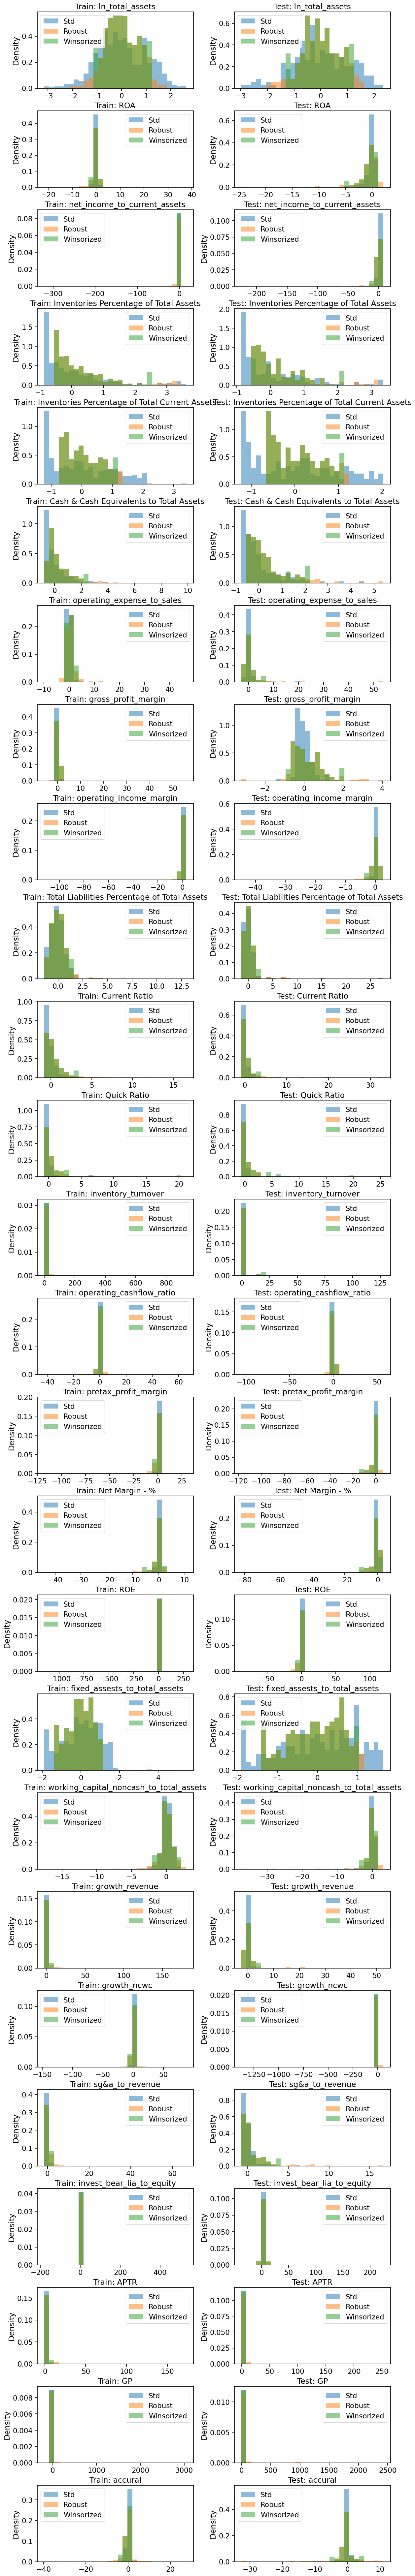

In [29]:
n_feat = len(cols)
fig, axes = plt.subplots(n_feat, 2, figsize=(12, 3 * n_feat), constrained_layout=True)

for i, col in enumerate(cols):
    # Train
    all_train = np.concatenate([X_train_std[:,i], X_train_rb[:,i], X_train_wins[:,i]])
    bins_train = np.linspace(all_train.min(), all_train.max(), 30)
    ax_train = axes[i, 0]
    ax_train.hist(X_train_std[:, i], bins=bins_train, alpha=0.5, label="Std", density=True)
    ax_train.hist(X_train_rb[:,  i], bins=bins_train, alpha=0.5, label="Robust", density=True)
    ax_train.hist(X_train_wins[:, i], bins=bins_train, alpha=0.5, label="Winsorized", density=True)
    ax_train.set_title(f"Train: {col}")
    ax_train.set_ylabel("Density")
    ax_train.legend()

    # Test
    all_test = np.concatenate([X_test_std[:,i], X_test_rb[:,i], X_test_wins[:,i]])
    bins_test = np.linspace(all_test.min(), all_test.max(), 30)
    ax_test = axes[i, 1]
    ax_test.hist(X_test_std[:, i], bins=bins_test, alpha=0.5, label="Std", density=True)
    ax_test.hist(X_test_rb[:,  i], bins=bins_test, alpha=0.5, label="Robust", density=True)
    ax_test.hist(X_test_wins[:, i], bins=bins_test, alpha=0.5, label="Winsorized", density=True)
    ax_test.set_title(f"Test: {col}")
    ax_test.set_ylabel("Density")
    ax_test.legend()

plt.show()

In [30]:
datasets = [("Standardized", X_train_std, X_test_std),
           ("Robust Scaled", X_train_rb, X_test_rb),
           ("Winsorized", X_train_wins, X_test_wins)]


for name, X_train, X_test in datasets:
    model = Sequential([Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
                        Dense(32, activation="relu"),
                        Dense(1, activation="sigmoid")])
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=100, batch_size=32,
            callbacks=[es],verbose=0)

    y_pred = model.predict(X_test).ravel()
    y_pred_class = (y_pred > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred_class)
    auc = roc_auc_score(y_test, y_pred)

    print(f"{name:8s} -> Accuracy: {acc:.4f}, AUC: {auc:.4f}") ## เดี๋ยวค่อยทำ plot

/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1753199493.708678   49172 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753199493.719240   49172 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Standardized -> Accuracy: 0.8495, AUC: 0.9185


/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Robust Scaled -> Accuracy: 0.8172, AUC: 0.8896


/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Winsorized -> Accuracy: 0.8387, AUC: 0.9061


#### Train test split

In [31]:
X_tr = X_train_std.copy()
y_tr = y_train.copy()
X_te = X_test_std.copy()
y_te = y_test.copy()

# sm = SMOTE(random_state=42, sampling_strategy='auto')

# X_tr_res, y_tr_res = sm.fit_resample(X_tr, y_tr)

# print("Before SMOTE:", np.bincount(y_tr))
# print("After  SMOTE:", np.bincount(y_tr_res))

### Build ANN for Keras

In [ ]:
def build_model(hp):
    model = Sequential()
    n_layers = hp.Int("n_layers", 1, 3)
    for i in range(n_layers):
        units = hp.Int(f"units_{i}", 32, 256, step=32)
        l2_val = hp.Float(f"l2_{i}", 1e-6, 1e-3, sampling="log")
        dropout_val = hp.Float(f"dropout_{i}", 0.2, 0.6, step=0.1)
        model.add(Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2_val),
                        input_shape=(X_tr.shape[1],) if i==0 else None))
        model.add(Dropout(dropout_val))
    model.add(Dense(1, activation="sigmoid"))
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")])
    return model


### Setting and turning by Keras tuner

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_auc",
    max_trials=20,
    executions_per_trial=1,
    directory="my_dir",
    project_name="ann_tuning")

earlystop = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)

tuner.search(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=50,
    batch_size=32,
    callbacks=[earlystop],
    verbose=1)


### Get the best hyperparesmeters

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
for i in range(best_hps.get("n_layers")):
    print(f" Layer {i}: units={best_hps.get(f'units_{i}')}, l2={best_hps.get(f'l2_{i}')}, dropout={best_hps.get(f'dropout_{i}')}")
print("Learning rate:", best_hps.get("learning_rate"))


### Build new model with best hyperparameters and train

In [ ]:
def build_best_model(best_hps):
    model = Sequential()
    n_layers = best_hps.get("n_layers")
    for i in range(n_layers):
        units = best_hps.get(f"units_{i}")
        l2_val = best_hps.get(f"l2_{i}")
        dropout_val = best_hps.get(f"dropout_{i}")
        model.add(Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2_val),
                        input_shape=(X_tr.shape[1],) if i==0 else None))
        model.add(Dropout(dropout_val))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=best_hps.get("learning_rate")),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")])
    return model

model = build_best_model(best_hps)
es = EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)
history = model.fit(
    X_tr, y_tr,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1)


### Evaluate performance

In [ ]:
def evaluate_model(model, X, y, set_name="Test"):
    prob = model.predict(X).ravel()
    pred = (prob > 0.5).astype(int)
    print(f"\n=== {set_name} Set Results ===")
    print("Accuracy:", accuracy_score(y, pred))
    print("AUC:     ", roc_auc_score(y, prob))
    print("Confusion Matrix:\n", confusion_matrix(y, pred))
    print("Classification Report:\n", classification_report(y, pred))

evaluate_model(model, X_te, y_te, "Test")
evaluate_model(model, X_tr, y_tr, "Training")


### Plot learning curve

In [ ]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Learning Curve')
plt.legend()
plt.show()

### ไม่น่าได้ใช้

In [ ]:
# def build_model(hp):
#     model = Sequential()
#     # Tune # hidden layers: 1–3
#     for i in range(hp.Int("n_layers", 1, 3)):
#         units = hp.Int(f"units_{i}", 32, 256, step=32)
#         l2_val = hp.Float(f"l2_{i}", 1e-6, 1e-3, sampling="log")
#         dropout_val = hp.Float(f"dropout_{i}", 0.2, 0.6, step=0.1)
#         model.add(Dense(units, activation="relu", kernel_regularizer=regularizers.l2(l2_val)))
#         model.add(Dropout(dropout_val))

#     # Tune learning rate: 1e-4 – 1e-2
#     lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=lr),
#         loss="binary_crossentropy",
#         metrics=['accuracy', AUC(name="auc")])
#     return model

# tuner = kt.RandomSearch(
#     build_model,
#     objective=kt.Objective("val_auc", direction="max"),
#     max_trials=20,
#     executions_per_trial=1,
#     directory="my_dir",
#     project_name="ann_tuning")

# tuner.search(
#     X_tr, y_tr,
#     validation_data=(X_te, y_te),
#     epochs=50,
#     batch_size=32,
#     callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
#     verbose=1)

# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print("Best learning rate:",     best_hps.get("learning_rate"))
# print("Best # hidden layers:",   best_hps.get("n_layers"))
# print("Best units in layer 0:",  best_hps.get("units_0"))
# print("Best units in layer 1:",  best_hps.get("units_1"))
# print("Best L2 reg value:",      best_hps.get("l2"))
# print("Best dropout rate:",      best_hps.get("dropout"))


Reloading Tuner from my_dir/ann_tuning/tuner0.json
Best learning rate: 0.007340641230095153
Best # hidden layers: 3
Best units in layer 0: 224
Best units in layer 1: 32
Best L2 reg value: 7.971024010324575e-06
Best dropout rate: 0.30000000000000004


In [ ]:
# model = Sequential()
# for i in range(best_hps.get("n_layers")):
#     units = best_hps.get(f"units_{i}")
#     l2_val = best_hps.get(f"l2_{i}")  # ถ้าแต่ละชั้นจูน l2 แยกกัน
#     dropout_val = best_hps.get(f"dropout_{i}")  # ถ้าแต่ละชั้นจูน dropout แยกกัน
#     model.add(Dense(
#         units,
#         activation="relu",
#         kernel_regularizer=regularizers.l2(l2_val),
#         input_shape=(X_tr.shape[1],) if i == 0 else None
#     ))
#     model.add(Dropout(dropout_val))

# model.compile(
#     optimizer=optimizers.Adam(learning_rate=best_hps.get("learning_rate")),
#     loss="binary_crossentropy",
#     metrics=[AUC(name="auc")])


# es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
# model.fit(X_tr, y_tr, 
#           validation_split=0.2,
#           epochs=100,
#           batch_size=32,
#           callbacks=[es], verbose=0)


# y_prob = model.predict(X_te).ravel()
# yy = model.predict(X_tr).ravel()
# y_pred = (y_prob > 0.5).astype(int)
# yx = (yy > 0.5).astype(int)

# print("Accuracy:", accuracy_score(y_te, y_pred))
# print("AUC:     ", roc_auc_score(y_te, y_prob))
# print("Accuracy on training set:", accuracy_score(y_tr, yx))
# print("AUC on training set:     ", roc_auc_score(y_tr, yy))
# print("Confusion Matrix:\n", confusion_matrix(y_te, y_pred))
# print("Confusion Matrix on training set:\n", confusion_matrix(y_tr, yx))
# print("Classification Report:\n", classification_report(y_te, y_pred))
# print("Classification Report on training set:\n", classification_report(y_tr, yx))



/mnt/d/SAVER/Research/Project/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8602150537634409
AUC:      0.9250693802035153
Accuracy on training set: 0.9192462987886945
AUC on training set:      0.9698605716273407
Confusion Matrix:
 [[76 16]
 [10 84]]
Confusion Matrix on training set:
 [[343  24]
 [ 36 340]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85        92
           1       0.84      0.89      0.87        94

    accuracy                           0.86       186
   macro avg       0.86      0.86      0.86       186
weighted avg       0.86      0.86      0.86       186

Classification Report on training set:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       367
           1       0.93      0.90      0.92       376

    accuracy                           0.92       743
   macro avg       0.92      0.92      0.92       743
weighted avg   

In [34]:
prec, rec, th = precision_recall_curve(y_te, y_prob)
# หา threshold ที่ maximize F1
f1_scores = 2*prec*rec/(prec+rec+1e-8)
best_ix = np.argmax(f1_scores)
best_thresh = th[best_ix]
print("Best threshold:", best_thresh, "F1:", f1_scores[best_ix])


Best threshold: 0.48785976 F1: 0.8775510154164932


In [35]:
feature_names = df2[cols].columns.tolist()
# 1) gather the Dense weight matrices in order:
weight_mats = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        W, b = layer.get_weights()
        weight_mats.append(W)      # W has shape (in_dim, out_dim)

# 2) multiply them all together: input → hidden1 → hidden2 → … → output
W_total = weight_mats[0]
for W in weight_mats[1:]:
    W_total = W_total.dot(W)     # chain the linear transforms

# after this, W_total has shape (n_features, 1)

# 3) feature importance = absolute value of those combined weights
importances = np.abs(W_total.flatten())   # shape (n_features,)

# 4) build a DataFrame (assuming you've defined feature_names)
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_imp)


                                           feature  importance
12                              inventory_turnover   93.401855
22                       invest_bear_lia_to_equity   29.879951
8                          operating_income_margin   25.926819
11                                     Quick Ratio   20.712376
6                       operating_expense_to_sales   19.482960
10                                   Current Ratio   16.766399
15                                  Net Margin - %   15.827873
7                              gross_profit_margin   15.496212
9     Total Liabilities Percentage of Total Assets   14.906235
21                                 sg&a_to_revenue   14.500973
3           Inventories Percentage of Total Assets   12.581095
23                                            APTR   12.053349
2                     net_income_to_current_assets   11.255569
14                            pretax_profit_margin   10.464756
18         working_capital_noncash_to_total_assets   10

# Compare features from t-stat and ML

In [36]:
df_compare = pd.DataFrame({'Top Std Features': pd.Series(feat_imp['feature'].tolist()),
                           'Significant t-test Features': pd.Series(sig_features)})

df_compare

Top Std Features  \
0                               inventory_turnover   
1                        invest_bear_lia_to_equity   
2                          operating_income_margin   
3                                      Quick Ratio   
4                       operating_expense_to_sales   
5                                    Current Ratio   
6                                   Net Margin - %   
7                              gross_profit_margin   
8     Total Liabilities Percentage of Total Assets   
9                                  sg&a_to_revenue   
10          Inventories Percentage of Total Assets   
11                                            APTR   
12                    net_income_to_current_assets   
13                            pretax_profit_margin   
14         working_capital_noncash_to_total_assets   
15                                             ROE   
16         Cash & Cash Equivalents to Total Assets   
17  Inventories Percentage of Total Current Assets   
18                                              GP   
19                   fixed_assests_to_total_assets   
20                                 ln_total_assets   
21                                             ROA   
22                                         accural   
23                                  growth_revenue   
24                        operating_cashflow_ratio   
25                                     growth_ncwc   

                     Significant t-test Features  
0                                ln_total_assets  
1                                            ROA  
2                   net_income_to_current_assets  
3         Inventories Percentage of Total Assets  
4        Cash & Cash Equivalents to Total Assets  
5                     operating_expense_to_sales  
6                            gross_profit_margin  
7                        operating_income_margin  
8   Total Liabilities Percentage of Total Assets  
9                                  Current Ratio  
10                                   Quick Ratio  
11                            inventory_turnover  
12                          pretax_profit_margin  
13                                Net Margin - %  
14       working_capital_noncash_to_total_assets  
15                                growth_revenue  
16                               sg&a_to_revenue  
17                     invest_bear_lia_to_equity  
18                                            GP  
19                                           NaN  
20                                           NaN  
21                                           NaN  
22                                           NaN  
23                                           NaN  
24                                           NaN  
25                                           NaN

# Models

## Prepare Data and Feature Selection

In [37]:
all_features = feat_imp["feature"].tolist()[:10]  # Select top 10 features
X_train_sel = pd.DataFrame(X_tr, columns=feat_imp["feature"].tolist())  # Use all features for now
X_train_sel = X_train_sel[all_features]  # Select only top 10
X_test_sel = pd.DataFrame(X_te, columns=feat_imp["feature"].tolist())
X_test_sel = X_test_sel[all_features]

print("Top 10 features ANN:", all_features)
print("X_train_sel shape:", X_train_sel.shape)
print("X_test_sel shape:", X_test_sel.shape)

Top 10 features ANN: ['inventory_turnover', 'invest_bear_lia_to_equity', 'operating_income_margin', 'Quick Ratio', 'operating_expense_to_sales', 'Current Ratio', 'Net Margin - %', 'gross_profit_margin', 'Total Liabilities Percentage of Total Assets', 'sg&a_to_revenue']
X_train_sel shape: (743, 10)
X_test_sel shape: (186, 10)


In [38]:
all_features_t = sig_features[:10]
X_train_t = pd.DataFrame(X_tr, columns=cols)
X_train_t = X_train_t[all_features_t]
X_test_t = pd.DataFrame(X_te, columns=cols)
X_test_t = X_test_t[all_features_t]

print("Top 10 features t-test:", all_features_t)
print("X_train_t shape:", X_train_t.shape)
print("X_test_t shape:", X_test_t.shape)

Top 10 features t-test: ['ln_total_assets', 'ROA', 'net_income_to_current_assets', 'Inventories Percentage of Total Assets', 'Cash & Cash Equivalents to Total Assets', 'operating_expense_to_sales', 'gross_profit_margin', 'operating_income_margin', 'Total Liabilities Percentage of Total Assets', 'Current Ratio']
X_train_t shape: (743, 10)
X_test_t shape: (186, 10)


#### Random Forest + GridSearchCV

In [39]:
from sklearn.ensemble    import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

In [40]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {"n_estimators":      [100, 300, 500],
                 "max_depth":         [5, 10, 20, None],
                 "max_features":      ["sqrt", "log2", 15, 26],
                 "min_samples_split": [2, 5, 10],
                 "min_samples_leaf":  [1, 5, 10],
                 "criterion":         ["gini", "entropy"]}

grid_rf = GridSearchCV(rf, param_grid_rf, scoring="roc_auc", cv=5, n_jobs=-1)

grid_rf.fit(X_train_sel, y_tr)

print("RF best params: ", grid_rf.best_params_)
print("RF CV AUC:     ", grid_rf.best_score_)
y_rf_prob = grid_rf.predict_proba(X_test_sel)[:, 1]
print("RF Test AUC:   ", roc_auc_score(y_te, y_rf_prob))

y_rf_pred = grid_rf.predict(X_test_sel)

print("RF Results:")
print("Accuracy:           ", accuracy_score(y_te, y_rf_pred))
print("ROC-AUC:            ", roc_auc_score(y_te, y_rf_prob))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_rf_pred))
print("Classification Report:\n", classification_report(y_te, y_rf_pred))

RF best params:  {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
RF CV AUC:      0.9347245269783123
RF Test AUC:    0.923913043478261
RF Results:
Accuracy:            0.8333333333333334
ROC-AUC:             0.923913043478261
Confusion Matrix:
 [[71 21]
 [10 84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82        92
           1       0.80      0.89      0.84        94

    accuracy                           0.83       186
   macro avg       0.84      0.83      0.83       186
weighted avg       0.84      0.83      0.83       186



In [41]:
best_rf = grid_rf.best_estimator_
# Feature importances from Random Forest
feat_imp_rf = pd.DataFrame({"feature": X_train_sel.columns,
                            "importance": best_rf.feature_importances_})
feat_imp_rf = feat_imp_rf.sort_values("importance", ascending=False)
feat_imp_rf

feature  importance
2                       operating_income_margin    0.132116
8  Total Liabilities Percentage of Total Assets    0.107471
3                                   Quick Ratio    0.105152
0                            inventory_turnover    0.103366
7                           gross_profit_margin    0.101222
9                               sg&a_to_revenue    0.099109
1                     invest_bear_lia_to_equity    0.090969
5                                 Current Ratio    0.090314
4                    operating_expense_to_sales    0.087933
6                                Net Margin - %    0.082349

In [ ]:
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {"n_estimators":      [100, 300, 500],
                 "max_depth":         [5, 10, 20, None],
                 "max_features":      ["sqrt", "log2", 15, 26],
                 "min_samples_split": [2, 5, 10],
                 "min_samples_leaf":  [1, 5, 10],
                 "criterion":         ["gini", "entropy"]}

grid_rf_t = GridSearchCV(rf, param_grid_rf, scoring="roc_auc", cv=5, n_jobs=-1)

grid_rf_t.fit(X_train_t, y_tr)

print("RF best params: ", grid_rf_t.best_params_)
print("RF CV AUC:     ", grid_rf_t.best_score_)
y_rf_prob_t = grid_rf_t.predict_proba(X_test_t)[:, 1]
print("RF Test AUC:   ", roc_auc_score(y_te, y_rf_prob_t))

y_rf_pred_t = grid_rf_t.predict(X_test_t)

print("RF Results:")
print("Accuracy:           ", accuracy_score(y_te, y_rf_pred_t))
print("ROC-AUC:            ", roc_auc_score(y_te, y_rf_prob_t))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_rf_pred_t))
print("Classification Report:\n", classification_report(y_te, y_rf_pred_t))

In [ ]:
best_rf_t = grid_rf_t.best_estimator_
# Feature importances from Random Forest
feat_imp_rf_t = pd.DataFrame({"feature": X_train_t.columns,
                            "importance": best_rf_t.feature_importances_})
feat_imp_rf_t = feat_imp_rf_t.sort_values("importance", ascending=False)
feat_imp_rf_t

In [ ]:
rf_results = pd.DataFrame({"Model": ["RF ANN Features", "RF T-Test Features"],
                           "ROC-AUC": [roc_auc_score(y_te, y_rf_prob), roc_auc_score(y_te, y_rf_prob_t)],
                           "Accuracy": [accuracy_score(y_te, y_rf_pred), accuracy_score(y_te, y_rf_pred_t)],
                           "Precision": [precision_score(y_te, y_rf_pred), precision_score(y_te, y_rf_pred_t)]})
rf_results

## Logistic Regression + GridSearchCV

In [ ]:
from sklearn.linear_model  import LogisticRegression

In [ ]:
pipe_lr = LogisticRegression(random_state=42)
param_grid_lr = [
    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["l1"],
     "solver":  ["liblinear", "saga"],
     "max_iter": [100, 1000, 2000, 5000]},
     
    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["l2"],
     "solver":  ["lbfgs", "liblinear", "newton-cg", "sag", "saga"],
     "max_iter": [100, 1000, 2000, 5000]},

    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["elasticnet"],
     "solver":  ["saga"],
     "max_iter": [100, 1000, 2000, 5000],
     "l1_ratio": [0.1, 0.5, 0.9]},  # เฉพาะ elasticnet ต้องระบุ l1_ratio ด้วย

    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["none"],
     "solver":  ["lbfgs", "newton-cg", "sag", "saga"],
     "max_iter": [100, 1000, 2000, 5000]}]

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring="roc_auc", cv=5, n_jobs=-1)

grid_lr.fit(X_train_sel, y_tr)

print("LR best params: ", grid_lr.best_estimator_)
print("LR CV AUC:     ", grid_lr.best_score_)
y_lr_prob = grid_lr.predict_proba(X_test_sel)[:, 1]
print("LR Test AUC:   ", roc_auc_score(y_te, y_lr_prob))

y_lr_pred = grid_lr.predict(X_test_sel)
print("LR Results:")
print("Accuracy:", accuracy_score(y_te, y_lr_pred))
print("ROC-AUC:", roc_auc_score(y_te, y_lr_prob))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_lr_pred))
print("Classification Report:\n", classification_report(y_te, y_lr_pred))

In [ ]:
best_lr = grid_lr.best_estimator_
# Feature importances from Logistic Regression
feat_imp_lr = pd.DataFrame({"feature": X_train_sel.columns,
                            "importance": np.abs(best_lr.coef_[0])})
feat_imp_lr = feat_imp_lr.sort_values("importance", ascending=False)
feat_imp_lr

In [ ]:
pipe_lr = LogisticRegression(random_state=42)
param_grid_lr = [
    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["l1"],
     "solver":  ["liblinear", "saga"],
     "max_iter": [100, 1000, 2000, 5000]},
     
    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["l2"],
     "solver":  ["lbfgs", "liblinear", "newton-cg", "sag", "saga"],
     "max_iter": [100, 1000, 2000, 5000]},

    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["elasticnet"],
     "solver":  ["saga"],
     "max_iter": [100, 1000, 2000, 5000],
     "l1_ratio": [0.1, 0.5, 0.9]},  # เฉพาะ elasticnet ต้องระบุ l1_ratio ด้วย

    {"C":       np.logspace(-4, 4, 20),
     "penalty": ["none"],
     "solver":  ["lbfgs", "newton-cg", "sag", "saga"],
     "max_iter": [100, 1000, 2000, 5000]}]


grid_lr_t = GridSearchCV(pipe_lr, param_grid_lr,scoring="roc_auc", cv=5, n_jobs=-1)

grid_lr_t.fit(X_train_t, y_tr)

print("LR best params: ", grid_lr_t.best_estimator_)
print("LR CV AUC:     ", grid_lr_t.best_score_)
y_lr_prob_t = grid_lr_t.predict_proba(X_test_t)[:, 1]
print("LR Test AUC:   ", roc_auc_score(y_te, y_lr_prob_t))

y_lr_pred_t = grid_lr_t.predict(X_test_t)
print("LR Results:")
print("Accuracy:", accuracy_score(y_te, y_lr_pred_t))
print("ROC-AUC:", roc_auc_score(y_te, y_lr_prob_t))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_lr_pred_t))
print("Classification Report:\n", classification_report(y_te, y_lr_pred_t))

In [ ]:
best_lr_t = grid_lr_t.best_estimator_
# Feature importances from Logistic Regression
feat_imp_lr_t = pd.DataFrame({"feature": X_train_t.columns,
                            "importance": np.abs(best_lr_t.coef_[0])})
feat_imp_lr_t = feat_imp_lr_t.sort_values("importance", ascending=False)
feat_imp_lr_t

In [ ]:
lr_results = pd.DataFrame({"Model": ["LR ANN Features", "LR T-Test Features"],
                           "ROC-AUC": [roc_auc_score(y_te, y_lr_prob), roc_auc_score(y_te, y_lr_prob_t)],
                           "Accuracy": [accuracy_score(y_te, y_lr_pred), accuracy_score(y_te, y_lr_pred_t)],
                           "Precision": [precision_score(y_te, y_lr_pred), precision_score(y_te, y_lr_pred_t)]})
lr_results

## SVM + GridSearchCV

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(probability=True, random_state=42)
param_grid_svc = [
    {"C":      [0.1, 1, 10, 100, 1000],
     "kernel": ["linear"]},

    {"C":      [0.1, 1, 10, 100, 1000],
     "kernel": ["rbf", "poly"],
     "gamma":  ["scale", "auto", 1, 0.1, 0.01, 0.001]}]

grid_svc = GridSearchCV(svc, param_grid_svc, scoring="roc_auc", cv=5, n_jobs=-1)

grid_svc.fit(X_train_sel, y_tr)

print("SVC best params:", grid_svc.best_params_)
print("SVC CV AUC:    ", grid_svc.best_score_)
y_svc_prob = grid_svc.predict_proba(X_test_sel)[:, 1]
print("SVC Test AUC:  ", roc_auc_score(y_te, y_svc_prob))

y_svc_pred = grid_svc.predict(X_test_sel)
print("SVC Results:")
print("Accuracy:", accuracy_score(y_te, y_svc_pred))
print("ROC-AUC:", roc_auc_score(y_te, y_svc_prob))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_svc_pred))
print("Classification Report:\n", classification_report(y_te, y_svc_pred))

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    grid_svc.best_estimator_, X_test_sel, y_te,
    n_repeats=10, random_state=42, n_jobs=-1)

feat_imp_svc = pd.DataFrame({
    "feature": X_test_sel.columns,
    "importance": result.importances_mean}).sort_values("importance", ascending=False)
feat_imp_svc

In [ ]:
svc = SVC(probability=True, random_state=42)
param_grid_svc = [
    {"C":      [0.1, 1, 10, 100, 1000],
     "kernel": ["linear"]},

    {"C":      [0.1, 1, 10, 100, 1000],
     "kernel": ["rbf", "poly"],
     "gamma":  ["scale", "auto", 1, 0.1, 0.01, 0.001]}]

grid_svc_t = GridSearchCV(svc, param_grid_svc, scoring="roc_auc", cv=5, n_jobs=-1)

grid_svc_t.fit(X_train_t, y_tr)

print("SVC best params:", grid_svc_t.best_params_)
print("SVC CV AUC:    ", grid_svc_t.best_score_)
y_svc_prob_t = grid_svc_t.predict_proba(X_test_t)[:, 1]
print("SVC Test AUC:  ", roc_auc_score(y_te, y_svc_prob_t))

y_svc_pred_t = grid_svc_t.predict(X_test_t)
print("SVC Results:")
print("Accuracy:", accuracy_score(y_te, y_svc_pred_t))
print("ROC-AUC:", roc_auc_score(y_te, y_svc_prob_t))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_svc_pred_t))
print("Classification Report:\n", classification_report(y_te, y_svc_pred_t))

In [ ]:
result_t = permutation_importance(
    grid_svc_t.best_estimator_, X_test_t, y_te,
    n_repeats=10, random_state=42, n_jobs=-1)

feat_imp_svc_t = pd.DataFrame({
    "feature": X_test_t.columns,
    "importance": result_t.importances_mean}).sort_values("importance", ascending=False)
feat_imp_svc_t

In [ ]:
svc_results = pd.DataFrame({"Model": ["SVM ANN Features", "SVM T-Test Features"],
                           "ROC-AUC": [roc_auc_score(y_te, y_svc_prob), roc_auc_score(y_te, y_svc_prob_t)],
                           "Accuracy": [accuracy_score(y_te, y_svc_pred), accuracy_score(y_te, y_svc_pred_t)],
                           "Precision": [precision_score(y_te, y_svc_pred), precision_score(y_te, y_svc_pred_t)]})
svc_results

## XGBoost + GridSearchCV

In [ ]:
import xgboost as xgb

In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

param_grid_xgb = {"max_depth":        [3, 5, 7],
                  "learning_rate":    [0.1, 0.01],
                  "subsample":        [0.7, 1],
                  "min_child_weight": [1, 10],
                  "gamma":            [1, 5],
                  "colsample_bytree": [0.8, 1],
                  "n_estimators":     [100, 200]}

grid_xgb = GridSearchCV(xgb_clf, param_grid_xgb, scoring="roc_auc", cv=5, n_jobs=-1)

grid_xgb.fit(X_train_sel, y_tr)

print("XGB best params:", grid_xgb.best_params_)
print("XGB CV AUC:    ", grid_xgb.best_score_)
y_xgb_prob = grid_xgb.predict_proba(X_test_sel)[:, 1]
print("XGB Test AUC:  ", roc_auc_score(y_te, y_xgb_prob))

y_xgb_pred = grid_xgb.predict(X_test_sel)
print("XGB Results:")
print("Accuracy:", accuracy_score(y_te, y_xgb_pred))
print("ROC-AUC:", roc_auc_score(y_te, y_xgb_prob))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_xgb_pred))
print("Classification Report:\n", classification_report(y_te, y_xgb_pred))

In [ ]:
best_xgb = grid_xgb.best_estimator_
# Feature importances from XGBoost
feat_imp_xgb = pd.DataFrame({"feature": X_train_sel.columns,
                             "importance": best_xgb.feature_importances_})
feat_imp_xgb = feat_imp_xgb.sort_values("importance", ascending=False)
feat_imp_xgb

In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

param_grid_xgb = {"max_depth":        [3, 5, 7],
                  "learning_rate":    [0.1, 0.01],
                  "subsample":        [0.7, 1],
                  "min_child_weight": [1, 10],
                  "gamma":            [1, 5],
                  "colsample_bytree": [0.8, 1],
                  "n_estimators":     [100, 200]}

grid_xgb_t = GridSearchCV(xgb_clf, param_grid_xgb, scoring="roc_auc", cv=5, n_jobs=-1)

grid_xgb_t.fit(X_train_t, y_tr)

print("XGB best params:", grid_xgb_t.best_params_)
print("XGB CV AUC:    ", grid_xgb_t.best_score_)
y_xgb_prob_t = grid_xgb_t.predict_proba(X_test_t)[:, 1]
print("XGB Test AUC:  ", roc_auc_score(y_te, y_xgb_prob_t))

y_xgb_pred_t = grid_xgb_t.predict(X_test_t)
print("XGB Results:")
print("Accuracy:", accuracy_score(y_te, y_xgb_pred_t))
print("ROC-AUC:", roc_auc_score(y_te, y_xgb_prob_t))
print("Confusion Matrix:\n", confusion_matrix(y_te, y_xgb_pred_t))
print("Classification Report:\n", classification_report(y_te, y_xgb_pred_t))

In [ ]:
best_xgb_t = grid_xgb_t.best_estimator_
# Feature importances from XGBoost
feat_imp_xgb_t = pd.DataFrame({"feature": X_train_t.columns,
                             "importance": best_xgb_t.feature_importances_})
feat_imp_xgb_t = feat_imp_xgb_t.sort_values("importance", ascending=False)
feat_imp_xgb_t

In [ ]:
xgb_results = pd.DataFrame({"Model": ["XGB ANN Features", "XGB T-Test Features"],
                           "ROC-AUC": [roc_auc_score(y_te, y_xgb_prob), roc_auc_score(y_te, y_xgb_prob_t)],
                           "Accuracy": [accuracy_score(y_te, y_xgb_pred), accuracy_score(y_te, y_xgb_pred_t)],
                           "Precision": [precision_score(y_te, y_xgb_pred), precision_score(y_te, y_xgb_pred_t)]})
xgb_results

In [ ]:
results = []
models = {
    "Random Forest":       (grid_rf,  y_rf_prob),
    "Logistic Regression": (grid_lr,  y_lr_prob),
    "SVM":                 (grid_svc, y_svc_prob),
    "XGBoost":             (grid_xgb, y_xgb_prob)}

for name, (grid, y_prob) in models.items():
    y_pred = grid.predict(X_test_sel)
    results.append({
        "Model":    name,
        "Accuracy": accuracy_score(y_te, y_pred),
        "ROC-AUC":  roc_auc_score(y_te, y_prob),
        "precision": precision_score(y_te, y_pred)})
  


comparison_df = pd.DataFrame(results).set_index("Model")
print(comparison_df)

In [ ]:
feats = {
    "RF":  feat_imp_rf.sort_values("importance", ascending=False).reset_index(drop=True),
    "LR":  feat_imp_lr.sort_values("importance", ascending=False).reset_index(drop=True),
    "SVM": feat_imp_svc.sort_values("importance", ascending=False).reset_index(drop=True),
    "XGB": feat_imp_xgb.sort_values("importance", ascending=False).reset_index(drop=True)
}
comparison_feats = pd.concat(feats, axis=1)
comparison_feats

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
fpr_rf,  tpr_rf,  _ = roc_curve(y_te, y_rf_prob)
fpr_lr,  tpr_lr,  _ = roc_curve(y_te, y_lr_prob)
fpr_svc, tpr_svc, _ = roc_curve(y_te, y_svc_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_te, y_xgb_prob)

auc_rf  = auc(fpr_rf,  tpr_rf)
auc_lr  = auc(fpr_lr,  tpr_lr)
auc_svc = auc(fpr_svc, tpr_svc)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf,  tpr_rf,  label=f"RandomForest (AUC={auc_rf:.3f})")
plt.plot(fpr_lr,  tpr_lr,  label=f"LogisticReg  (AUC={auc_lr:.3f})")
plt.plot(fpr_svc, tpr_svc, label=f"SVM (AUC={auc_svc:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.3f})")

plt.plot([0,1],[0,1], 'k--', label="Random guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

####  What's next 
1. plot graph
2. tune overfit
3. why SMOTE?
4. เริ่มเขียน method, result, lit->  31 Jul 14.00